<a href="https://colab.research.google.com/github/vikramsh2004/SynapseCLR-Library/blob/main/modified_notebook_01_testdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocess raw 3D EM image chunks

- Convert 256 x 256 x 256 EM and segmentation masks at ~ 8 nm x 8 nm x 40 nm resolution to 2 x 256 x 256 x 52 uint8 tensors. We only keep the central z-sections and remove the unwanted extra context. The two channels corresponds to EM intensity and integer-encoded segmentation masks.
- Generate a .csv table of all image chunks and associated metadata

In [18]:
import sys
from types import ModuleType

# 1. Create a dummy module for synapse_augmenter
m = ModuleType("synapse_augmenter")

# 2. Create a dummy module for consts
consts_mod = ModuleType("consts")

# 3. Define the constants the script expects
# IMPORTANT: If your mask integers are different (e.g., 255 for cleft), change them here.
consts_mod.MASK_PRE_SYNAPTIC_NEURON = 1
consts_mod.MASK_SYNAPTIC_CLEFT = 2
consts_mod.MASK_POST_SYNAPTIC_NEURON = 3

# 4. Attach consts to synapse_augmenter
m.consts = consts_mod

# 5. Inject it into sys.modules so Python thinks it's installed
sys.modules["synapse_augmenter"] = m

print("Successfully mocked synapse_augmenter. You can now run the import cell.")

Successfully mocked synapse_augmenter. You can now run the import cell.


In [19]:
import os
import sys
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import logging

from typing import Tuple
import bisect
from collections import Counter
from operator import itemgetter

from synapse_augmenter import consts

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use('dark_background')

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = print

## Configuration

In [20]:
# Configuration

# Use the specific paths you provided
raw_em_data_path = 'C:/Users/crazy/Downloads/SynapseCLR_Work/Raw'
raw_mask_data_path = 'C:/Users/crazy/Downloads/SynapseCLR_Work/Raw_Mask'
proc_data_path = 'C:/Users/crazy/Downloads/SynapseCLR_Work/Processed'

In [21]:
# hyperparameters

# promote sections with at least this much fraction of cutout pixels to fully masked
cutout_threshold = 0.01

# z spacing vs. xy spacing
axial_to_sagittal_spacing = 5

seg_mask_map = {
    'MASK_PRE_SYNAPTIC_NEURON': consts.MASK_PRE_SYNAPTIC_NEURON,
    'MASK_SYNAPTIC_CLEFT': consts.MASK_SYNAPTIC_CLEFT,
    'MASK_POST_SYNAPTIC_NEURON': consts.MASK_POST_SYNAPTIC_NEURON
}

# which segmentation region(s) to cut the EM data with?
cut_intensity_with_seg_masks = False
output_channel_desc = [
    (consts.MASK_PRE_SYNAPTIC_NEURON,),
    (consts.MASK_SYNAPTIC_CLEFT,),
    (consts.MASK_POST_SYNAPTIC_NEURON,)
]

## List of all images

In [22]:
import zipfile
import os

# Adjust 'SynapseCLR_Work.zip' if you named it something else
zip_path = "SynapseCLR_Work.zip"

if os.path.exists(zip_path):
    print("Unzipping data...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("✅ Done! Data is now in the cloud environment.")
else:
    print("❌ Zip file not found. Please upload 'SynapseCLR_Work.zip' to the Files sidebar.")

Unzipping data...
✅ Done! Data is now in the cloud environment.


In [23]:
# Linux paths for Cloud/Colab
# Note: No 'C:/', no 'Users'
raw_em_data_path = '/content/SynapseCLR_Work/Raw'
raw_mask_data_path = '/content/SynapseCLR_Work/Raw_Mask'
proc_data_path = '/content/SynapseCLR_Work/Processed'

# Create the output directory if it doesn't exist
import os
os.makedirs(proc_data_path, exist_ok=True)

In [24]:
import os

# --- 1. Load EM Files ---
print(f"Scanning EM path: {raw_em_data_path}")
if not os.path.exists(raw_em_data_path):
    print("❌ ERROR: The EM path does not exist! Check for typos.")
else:
    raw_em_data_file_path_list = []
    for dirpath, _, filenames in os.walk(raw_em_data_path):
        for filename in filenames:
            # CORRECT logic: ensure it ends with .npy
            if filename.endswith('.npy'):
                raw_em_data_file_path_list.append(os.path.join(dirpath, filename))

    print(f"✅ Found {len(raw_em_data_file_path_list)} EM files (.npy)")


# --- 2. Load Mask Files ---
print(f"\nScanning Mask path: {raw_mask_data_path}")
if not os.path.exists(raw_mask_data_path):
    print("❌ ERROR: The Mask path does not exist! Check for typos.")
else:
    raw_mask_data_file_path_list = []
    for dirpath, _, filenames in os.walk(raw_mask_data_path):
        for filename in filenames:
            if filename.endswith('.npy'):
                raw_mask_data_file_path_list.append(os.path.join(dirpath, filename))

    print(f"✅ Found {len(raw_mask_data_file_path_list)} Mask files (.npy)")

Scanning EM path: /content/SynapseCLR_Work/Raw
✅ Found 10 EM files (.npy)

Scanning Mask path: /content/SynapseCLR_Work/Raw_Mask
✅ Found 10 Mask files (.npy)


In [25]:
# make a dataframe

def get_id_from_em_data_path(em_data_path: str) -> str:
    return em_data_path.split('/')[-1].split('.')[0]

def get_id_from_mask_data_path(mask_data_path: str) -> str:
    return mask_data_path.split('/')[-1].split('.')[0].split('_')[0]

synapse_id_to_em_data_path_map = {
    get_id_from_em_data_path(em_data_path): em_data_path
    for em_data_path in raw_em_data_file_path_list
}

synapse_id_to_mask_data_path_map = {
    get_id_from_mask_data_path(mask_data_path): mask_data_path
    for mask_data_path in raw_mask_data_file_path_list
}

# synapose IDs with both EM data and mask data
complete_synapse_id_set = set(synapse_id_to_em_data_path_map.keys()).intersection(set(synapse_id_to_mask_data_path_map.keys()))
complete_synapse_id_list = sorted(list(complete_synapse_id_set))
complete_em_data_path_list = list(map(synapse_id_to_em_data_path_map.get, complete_synapse_id_list))
complete_mask_data_path_list = list(map(synapse_id_to_mask_data_path_map.get, complete_synapse_id_list))

In [26]:
def load_em_data_and_mask(synapse_id: str) -> Tuple[np.ndarray, np.ndarray]:
    assert synapse_id in complete_synapse_id_set
    em_data_xyz = np.load(synapse_id_to_em_data_path_map[synapse_id])
    mask_data_xyz = np.load(synapse_id_to_mask_data_path_map[synapse_id])
    return em_data_xyz, mask_data_xyz

## Estimate cutout pixel fraction across the stack

In [27]:
def get_cutout_fraction_z(img_xyz: np.ndarray, cutout_pixel_value: int = 0) -> float:
    section_area = img_xyz.shape[0] * img_xyz.shape[1]
    cutout_fraction_z = np.sum(img_xyz == cutout_pixel_value, axis=(0, 1)) / section_area
    return cutout_fraction_z

In [28]:
import os

# 1. Check if files were found at all
print(f"Total EM files found: {len(raw_em_data_file_path_list)}")
print(f"Total Mask files found: {len(raw_mask_data_file_path_list)}")

# 2. Inspect the first file to see how the ID extraction works
if len(raw_em_data_file_path_list) > 0:
    sample_em = raw_em_data_file_path_list[0]
    em_filename = os.path.basename(sample_em)
    em_id = get_id_from_em_data_path(sample_em)
    print(f"\n--- EM SAMPLE ---")
    print(f"File: {em_filename}")
    print(f"Extracted ID: '{em_id}'")

if len(raw_mask_data_file_path_list) > 0:
    sample_mask = raw_mask_data_file_path_list[0]
    mask_filename = os.path.basename(sample_mask)
    mask_id = get_id_from_mask_data_path(sample_mask)
    print(f"\n--- MASK SAMPLE ---")
    print(f"File: {mask_filename}")
    print(f"Extracted ID: '{mask_id}'")

Total EM files found: 10
Total Mask files found: 10

--- EM SAMPLE ---
File: data_MICrONS__L23__8_8_40__raw_1000379.npy
Extracted ID: 'data_MICrONS__L23__8_8_40__raw_1000379'

--- MASK SAMPLE ---
File: data_MICrONS__L23__8_8_40__masks_1000348_mask.npy
Extracted ID: 'data'


In [29]:
# DIAGNOSTIC CELL - Run this to see why the match is failing

print("--- DIAGNOSTICS ---")
print(f"Number of EM files loaded: {len(raw_em_data_file_path_list)}")
print(f"Number of Mask files loaded: {len(raw_mask_data_file_path_list)}")

if len(raw_em_data_file_path_list) > 0:
    print("\nExample EM file path:", raw_em_data_file_path_list[0])
    print("Example EM ID extracted:", get_id_from_em_data_path(raw_em_data_file_path_list[0]))
else:
    print("\n❌ EM file list is empty! Check your 'raw_em_data_path' variable.")

if len(raw_mask_data_file_path_list) > 0:
    print("\nExample Mask file path:", raw_mask_data_file_path_list[0])
    print("Example Mask ID extracted:", get_id_from_mask_data_path(raw_mask_data_file_path_list[0]))
else:
    print("\n❌ Mask file list is empty! Check your 'raw_mask_data_path' variable.")

--- DIAGNOSTICS ---
Number of EM files loaded: 10
Number of Mask files loaded: 10

Example EM file path: /content/SynapseCLR_Work/Raw/data_MICrONS__L23__8_8_40__raw_1000379.npy
Example EM ID extracted: data_MICrONS__L23__8_8_40__raw_1000379

Example Mask file path: /content/SynapseCLR_Work/Raw_Mask/data_MICrONS__L23__8_8_40__masks_1000348_mask.npy
Example Mask ID extracted: data


In [30]:
# make a dataframe
import os

def get_id_from_em_data_path(em_data_path: str) -> str:
    filename = os.path.basename(em_data_path)
    # Example: data_..._raw_1000379.npy
    # 1. Remove .npy extension -> data_..._raw_1000379
    # 2. Split by underscore and take the last part -> 1000379
    return filename.replace('.npy', '').split('_')[-1]

def get_id_from_mask_data_path(mask_data_path: str) -> str:
    filename = os.path.basename(mask_data_path)
    # Example: data_..._masks_1000348_mask.npy
    # 1. Remove '_mask.npy' suffix -> data_..._masks_1000348
    # 2. Split by underscore and take the last part -> 1000348
    return filename.replace('_mask.npy', '').split('_')[-1]

synapse_id_to_em_data_path_map = {
    get_id_from_em_data_path(em_data_path): em_data_path
    for em_data_path in raw_em_data_file_path_list
}

synapse_id_to_mask_data_path_map = {
    get_id_from_mask_data_path(mask_data_path): mask_data_path
    for mask_data_path in raw_mask_data_file_path_list
}

# synapse IDs with both EM data and mask data
complete_synapse_id_set = set(synapse_id_to_em_data_path_map.keys()).intersection(set(synapse_id_to_mask_data_path_map.keys()))
complete_synapse_id_list = sorted(list(complete_synapse_id_set))
complete_em_data_path_list = list(map(synapse_id_to_em_data_path_map.get, complete_synapse_id_list))
complete_mask_data_path_list = list(map(synapse_id_to_mask_data_path_map.get, complete_synapse_id_list))

print(f"Found {len(complete_synapse_id_list)} matching pairs.")

Found 10 matching pairs.


In [32]:
# --- Calculation Cell (Run this BEFORE the plot) ---

import numpy as np

# 1. Settings (Reduced samples for testing)
n_rand_samples = 10
log_freq = 1
n_bins = 100

print(f"Starting to process {n_rand_samples} random samples...")

# Initialize 'values' just in case the loop fails
values = np.linspace(0, 1, n_bins + 1)
hist = np.zeros((n_bins,))

success_count = 0

for i_img in range(n_rand_samples):

    try:
        if i_img % log_freq == 0:
            print(f"Processing sample {i_img + 1} / {n_rand_samples} ...")

        # Check if we have IDs to pick from
        if len(complete_synapse_id_list) == 0:
            print("❌ ERROR: 'complete_synapse_id_list' is empty! You must re-run the ID matching cell (Cell 8).")
            break

        # load a random image
        synapse_index = np.random.randint(0, len(complete_synapse_id_list))
        synapse_id = complete_synapse_id_list[synapse_index]

        # Load data
        img_xyz, _ = load_em_data_and_mask(synapse_id)

        # estimate cutout fraction and histogram
        cutout_fraction_z = get_cutout_fraction_z(img_xyz)
        c_hist, values = np.histogram(cutout_fraction_z, bins=n_bins)

        # accumulate histogram
        hist += c_hist
        success_count += 1

    except Exception as e:
        print(f"⚠️ Error processing image {i_img}: {e}")
        continue

if success_count > 0:
    # Normalize
    hist = hist / (success_count * img_xyz.shape[2])
    print("✅ Calculation finished successfully. 'values' is now defined.")
else:
    print("❌ Calculation failed for all images.")

Starting to process 10 random samples...
Processing sample 1 / 10 ...
Processing sample 2 / 10 ...
Processing sample 3 / 10 ...
Processing sample 4 / 10 ...
Processing sample 5 / 10 ...
Processing sample 6 / 10 ...
Processing sample 7 / 10 ...
Processing sample 8 / 10 ...
Processing sample 9 / 10 ...
Processing sample 10 / 10 ...
✅ Calculation finished successfully. 'values' is now defined.


Text(0, 0.5, 'Fraction of sections')

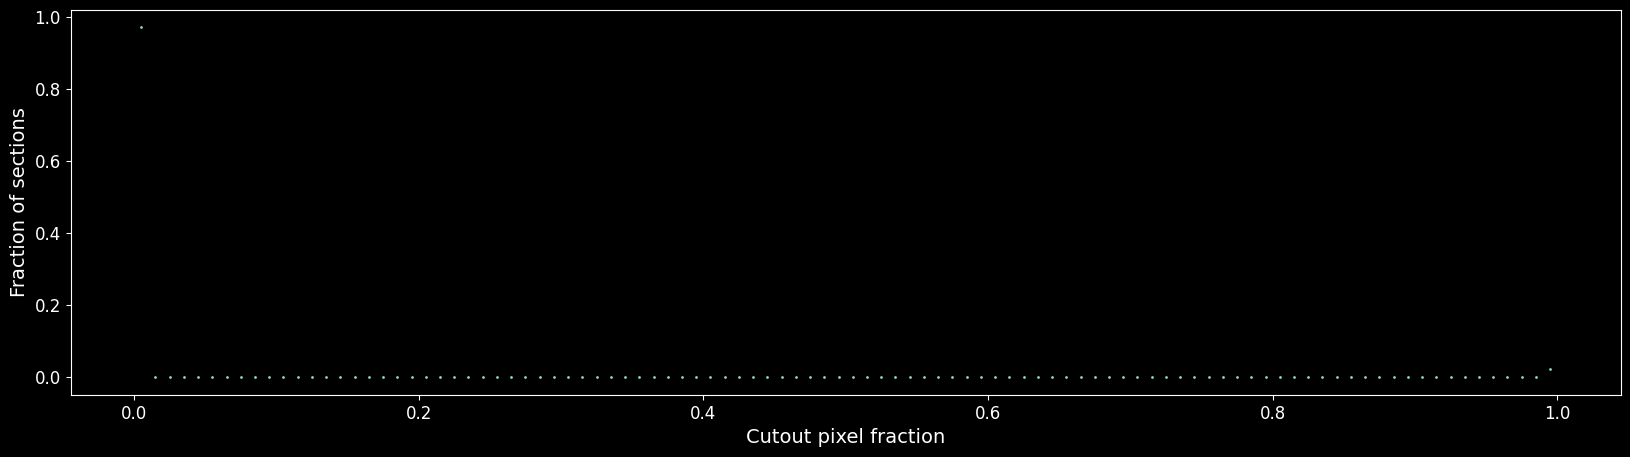

In [33]:
mid_points = 0.5 * (values[1:] + values[:-1])

fig = plt.figure(figsize=(20, 5))
ax = plt.gca()

ax.scatter(mid_points, hist, s=1)
ax.set_xlabel('Cutout pixel fraction')
ax.set_ylabel('Fraction of sections')
# ax.set_yscale('log')

In [34]:
assert cutout_threshold >= values[1] - values[0]
lo_idx = bisect.bisect_left(values, cutout_threshold)
total_weight_lo_cutout = np.sum(hist[:lo_idx])
total_weight_hi_cutout = np.sum(hist[lo_idx:])

log_info(f'Fraction of sections with less than {cutout_threshold} fraction masking: {total_weight_lo_cutout}')
log_info(f'Fraction of sections with more than {cutout_threshold} fraction masking: {total_weight_hi_cutout}')

Fraction of sections with less than 0.01 fraction masking: 0.971484375
Fraction of sections with more than 0.01 fraction masking: 0.028515625


## Intensity histogram of non-masked sections

In [35]:
n_rand_samples = 10
log_freq = 100

intensity_counter = Counter()

for i_img in range(n_rand_samples):

    if i_img % log_freq == 0:
        log_info(f"Processing {i_img + 1} / {n_rand_samples} ...")

    # load a random image
    synapse_index = np.random.randint(0, len(complete_synapse_id_list))
    img_xyz, _ = load_em_data_and_mask(complete_synapse_id_list[synapse_index])

    # calcualte cutout fraction for each section
    cutout_fraction_z = get_cutout_fraction_z(img_xyz)
    sub_threshold_cutout_sections_z = cutout_fraction_z <= cutout_threshold
    img_xyz = img_xyz[:, :, sub_threshold_cutout_sections_z]

    # update indensity counter
    intensity_counter.update(img_xyz.flatten())


Processing 1 / 10 ...


Text(0, 0.5, 'Pixel count')

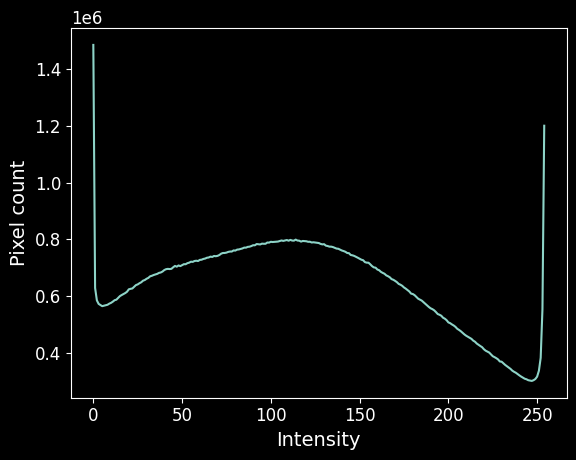

In [36]:
intensity_hist = list(map(itemgetter(1), sorted(list(dict(intensity_counter).items()), key=itemgetter(0))))[1:]

fig = plt.figure()
ax = plt.gca()

ax.plot(intensity_hist)
ax.set_xlabel('Intensity')
ax.set_ylabel('Pixel count')

## Section-to-section intensity variation estimate

In [37]:
n_rand_samples = 10
log_freq = 100

section_to_section_relative_intensity_list = []

for i_img in range(n_rand_samples):

    if i_img % log_freq == 0:
        log_info(f"Processing {i_img + 1} / {n_rand_samples} ...")

    # load a random image
    synapse_index = np.random.randint(0, len(complete_synapse_id_list))
    img_xyz, _ = load_em_data_and_mask(complete_synapse_id_list[synapse_index])

    # calcualte cutout fraction for each section
    cutout_fraction_z = get_cutout_fraction_z(img_xyz)
    sub_threshold_cutout_sections_z = cutout_fraction_z <= cutout_threshold
    img_xyz = img_xyz[:, :, sub_threshold_cutout_sections_z]

    section_mean_z = np.mean(img_xyz, axis=(0, 1))
    relative_section_mean_z = section_mean_z[:-1] / (1e-8 + section_mean_z[1:])

    section_to_section_relative_intensity_list += relative_section_mean_z.tolist()
    break

Processing 1 / 10 ...


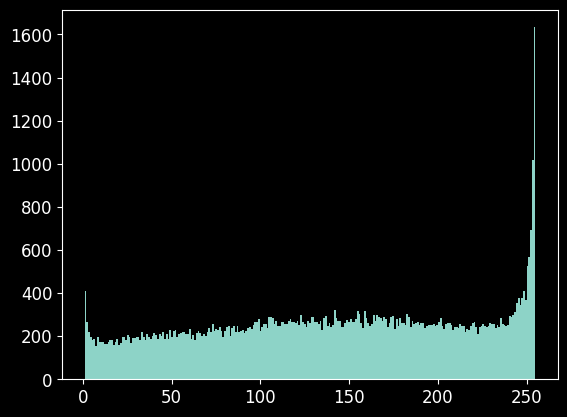

In [38]:
plt.hist(img_xyz[:, :, 13].flatten(), bins=255);

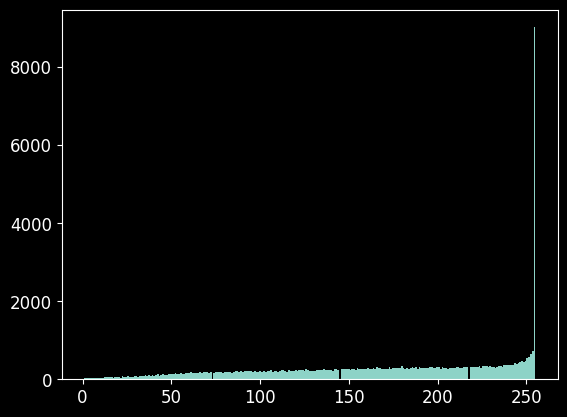

In [40]:
a = 1.01
b = 0
intensity_tansform = lambda x: np.clip(a * x + b, a_min=0., a_max=255.)

# Change .astype(np.float) to .astype(float)
plt.hist(intensity_tansform(img_xyz[:, :, 14].astype(float).flatten()), bins=255);

## Data preprocessing

For each image:

- Keep track of the number sections with supra-threshold cutout pixels
- Mask the entire section with supra-threshold cutout pixels
- Center crop to (256, 256, 256 // axial_to_sagittal_spacing + 1)
- Generate output channels by applying segmentation mask to EM data

In [41]:
def center_crop_3d_np(layer: np.ndarray, target_shape: Tuple[int]) -> np.ndarray:
    layer_depth, layer_height, layer_width = layer.shape
    target_depth, target_height, target_width = target_shape
    assert layer_depth >= target_depth
    assert layer_height >= target_height
    assert layer_width >= target_width
    diff_x = (layer_width - target_width) // 2
    diff_y = (layer_height - target_height) // 2
    diff_z = (layer_depth - target_depth) // 2
    return layer[
        diff_z:(diff_z + target_depth),
        diff_y:(diff_y + target_height),
        diff_x:(diff_x + target_width)]

In [42]:
os.makedirs(proc_data_path, exist_ok=True)

log_frequency = 500

out_filename_list = []
n_cutout_sections_list = []
pre_synaptic_neuron_volume_list = []
post_synaptic_neuron_volume_list = []
synaptic_cleft_volume_list = []

for i_synapse, synapse_id in enumerate(complete_synapse_id_list):

    # load raw data
    em_xyz, mask_xyz = load_em_data_and_mask(synapse_id)

    # match axial and sagittal resolutions and re-crop (for EM data)
    orig_shape = em_xyz.shape
    final_shape = orig_shape[0], orig_shape[1], (orig_shape[2] // axial_to_sagittal_spacing + 1)
    em_xyz = center_crop_3d_np(em_xyz, final_shape)

    # match axial and sagittal resolutions and re-crop (for mask data)
    orig_shape = mask_xyz.shape
    final_shape = orig_shape[0], orig_shape[1], (orig_shape[2] // axial_to_sagittal_spacing + 1)
    mask_xyz = center_crop_3d_np(mask_xyz, final_shape)

    # calcualte masked fraction for each section
    cutout_fraction_z = get_cutout_fraction_z(em_xyz)
    supra_threshold_cutout_sections_z = cutout_fraction_z > cutout_threshold
    n_cutout_sections = np.sum(supra_threshold_cutout_sections_z)

    # promote partially masked to fully masked
    em_xyz[:, :, supra_threshold_cutout_sections_z] = 0

    if cut_intensity_with_seg_masks:

        # generate output channels
        n_output_channels = len(output_channel_desc) + 1
        out_cxyz = np.zeros((n_output_channels,) + em_xyz.shape, dtype=em_xyz.dtype)

        # cut the EM data with mask combinations
        for i_output_channel, seg_mask_tuple in enumerate(output_channel_desc):
            combined_mask_xyz = np.zeros_like(mask_xyz)
            for seg_mask_value in seg_mask_tuple:
                combined_mask_xyz = combined_mask_xyz | (mask_xyz == seg_mask_value)
            out_cxyz[i_output_channel, ...] = combined_mask_xyz * em_xyz

        # include the integer segmentation mask as the last channel
        out_cxyz[-1, ...] = mask_xyz

    else:

        # intensity and integer seg mask
        n_output_channels = 2
        out_cxyz = np.zeros((n_output_channels,) + em_xyz.shape, dtype=em_xyz.dtype)
        out_cxyz[0, ...] = em_xyz
        out_cxyz[1, ...] = mask_xyz

    # statistics
    pre_synaptic_neuron_volume = axial_to_sagittal_spacing * np.sum(mask_xyz == consts.MASK_PRE_SYNAPTIC_NEURON)
    post_synaptic_neuron_volume = axial_to_sagittal_spacing * np.sum(mask_xyz == consts.MASK_POST_SYNAPTIC_NEURON)
    synaptic_cleft_volume = axial_to_sagittal_spacing * np.sum(mask_xyz == consts.MASK_SYNAPTIC_CLEFT)

    # save
    out_filename = f"{synapse_id}__{'_'.join([str(x) for x in out_cxyz.shape])}.npy"
    np.save(os.path.join(proc_data_path, out_filename), out_cxyz)

    # bookkeeping
    out_filename_list.append(out_filename)
    n_cutout_sections_list.append(n_cutout_sections)
    pre_synaptic_neuron_volume_list.append(pre_synaptic_neuron_volume)
    post_synaptic_neuron_volume_list.append(post_synaptic_neuron_volume)
    synaptic_cleft_volume_list.append(synaptic_cleft_volume)

    if i_synapse % log_frequency == 0:
        log_info(f'Processing {i_synapse + 1} / {len(complete_synapse_id_list)} ...')

Processing 1 / 10 ...


## Save the metadata

In [43]:
proc_data_df = pd.DataFrame(
    {
        'synapse_id': pd.Series(complete_synapse_id_list, dtype='str'),
        'filename': pd.Series(out_filename_list, dtype='str'),
        'pre_synaptic_volume': pd.Series(pre_synaptic_neuron_volume_list, dtype='float'),
        'post_synaptic_volume': pd.Series(post_synaptic_neuron_volume_list, dtype='float'),
        'synaptic_cleft_volume': pd.Series(synaptic_cleft_volume_list, dtype='float'),
        'n_cutout_sections': pd.Series(n_cutout_sections_list, dtype='int')
    }
)

# save
proc_data_df.to_csv(os.path.join(proc_data_path, 'meta.csv'), index=False)

## Merge datasets

If multiple downloaded datasets are processed, we need to merge the metdata to make a single dataset.

In [44]:
meta_list = [
    'path/to/processed/dataset_1/meta.csv',
    'path/to/processed/dataset_2/meta.csv',
    'path/to/processed/dataset_3/meta.csv',
]

merged_meta_path = 'path/to/processed/dataset_merged/meta.csv'

meta_df_list = [pd.read_csv(meta_path, index_col='synapse_id') for meta_path in meta_list]
merged_meta_df = pd.concat(meta_df_list, sort=True)

merged_meta_df = merged_meta_df.drop_duplicates().reset_index(drop=False)

# save
merged_meta_df.to_csv(merged_meta_path, index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/processed/dataset_1/meta.csv'